In [1]:
import os
from warnings import simplefilter
from typing import List, Optional, Callable

In [2]:
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

#### Configure path parameters and read data files

In [3]:
MIDS_USER = os.getenv("MIDS_USER", None)  # this can be replaced, with e.g. `m25...`

#if MIDS_USER is None:
#  ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), *['..'] * 1)) 
#else:
 # ROOT_DIR = f"/home/mids/{MIDS_USER}/Capstone"

#IMAGES_DIR = os.path.join(ROOT_DIR, "data", "datasets", "aircraft", "images")
#f not os.path.exists(IMAGES_DIR):
  #ROOT_DIR = os.path.join(ROOT_DIR, "lc-14")
 # IMAGES_DIR = os.path.join(ROOT_DIR, "data", "datasets", "aircraft", "images")
ROOT_DIR = '/home/mids/m254572/Capstone'
IMAGES_DIR = os.path.join(ROOT_DIR, "data", "aircraft", "images")
RADOM_SEED = 2020
TRAIN_FRAC = 0.8
VAL_FRAC = 0.1

NUM_EPOCHS = 20  # This can be adjusted as needed 

In [4]:
image_dir = IMAGES_DIR
labels_fp = os.path.join(ROOT_DIR, "data", "aircraft", "annotations.csv")

#### Load utility functions

In [5]:
os.chdir(ROOT_DIR)

In [6]:
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2

from src.utilities.data.aircraft_dataloader import get_dataloader

#### Define an image transformation pipeline

In [7]:
transformations = A.Compose([
  A.Resize(256, 256),  # This transform resizes each image before subsequent processing
  A.HorizontalFlip(p=0.5),  # This transform flips each image horizontally with a probability of 0.5
  A.RandomBrightnessContrast(p=0.2),  # This transform randomly adjusts the brightness and contrast of each image with a probability of 0.2
  A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # This transformation normalizes from standard RGB to grayscale
  ToTensorV2(),  # This transform maps our image to a torch.Tensor object
])

#### Building a `torch.Dataloader`.

In [8]:
# Create the DataLoader
dataloader = get_dataloader(
  image_dir=image_dir,
  labels_fp=labels_fp,
  transformations=transformations,
  mode='train',
  train_frac=TRAIN_FRAC,
  val_frac=VAL_FRAC,
  seed=RADOM_SEED,
  batch_size=1,
  shuffle=True,
  num_workers=1,
)

#### Building a CNN using `torch.nn.Module`

In [9]:
class BaselineCNN(nn.Module):
  def __init__(self):
    super(ExampleCNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc = nn.Linear(32 * 64 * 64, 1)

  def forward(self, x):
    # Apply two pooling layers
    x = self.pool1(
      torch.relu(
        self.conv1(x)  # Pass the input through the first convolutional layer
      )  # Apply the ReLU activation function to the output of the first convolutional layer
    )  # Apply the first pooling layer
    x = self.pool2(
      torch.relu(
        self.conv2(x)  # Pass the output of the first convolutional layer through the second convolutional layer}
      )  # Apply the ReLU activation function to the output of the second convolutional layer
    )  # Apply the second pooling layer

    x = x.view(-1, 32 * 64 * 64)  # Flatten after pooling

    x = torch.relu(
      self.fc(x)
    )  # Pass the flattened input through the fully connected layer
    return x


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MunozCNN(nn.Module):
  def __init__(self):
    super(MunozCNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(16) 
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(32) 
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc = nn.Linear(32 * 64 * 64, 1)

  def forward(self, x):
    x = self.pool1(F.relu(self.bn1(self.conv1(x))))  # Conv1 → BatchNorm → ReLU → Pool
    x = self.pool2(F.relu(self.bn2(self.conv2(x))))  # Conv2 → BatchNorm → ReLU → Pool

    x = x.view(-1, 32 * 64 * 64)  # Flatten for fully connected layer
    x = self.fc(x)  # Linear layer (output)

    return x

    

#### Training the model

In [11]:
# Basic hyperparameters
learning_rate = 1e-5

In [12]:
example_model = MunozCNN()
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(example_model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(NUM_EPOCHS):
  for i, (images, targets) in enumerate(dataloader):
    if i == len(dataloader) - 1: continue  # save the last batch for demonstration
    # Forward pass
    outputs = example_model(images)
    loss = criterion(outputs.squeeze(), targets)  # Ensure outputs are squeezed to match counts shape

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}")


Epoch [1/20], Loss: 0.9022
Epoch [2/20], Loss: 6.5308
Epoch [3/20], Loss: 611.8740
Epoch [4/20], Loss: 3108.2458
Epoch [5/20], Loss: 492.0648
Epoch [6/20], Loss: 80.6562
Epoch [7/20], Loss: 515.9671
Epoch [8/20], Loss: 287.8860
Epoch [9/20], Loss: 6.2318
Epoch [10/20], Loss: 6.8005
Epoch [11/20], Loss: 35.9507
Epoch [12/20], Loss: 0.0000
Epoch [13/20], Loss: 1.0970
Epoch [14/20], Loss: 110.5076
Epoch [15/20], Loss: 8.7168
Epoch [16/20], Loss: 152.4172
Epoch [17/20], Loss: 100.8800
Epoch [18/20], Loss: 393.8560
Epoch [19/20], Loss: 22.5078
Epoch [20/20], Loss: 0.0104


Check the model's prediction on the validation set for a `torch.Dataset` with the same `train_frac`, `val_frac`, and `seed`.

In [13]:
# Create the DataLoader
val_dataloader = get_dataloader(
  image_dir,
  labels_fp,
  transformations=transformations,
  mode='val',
  train_frac=TRAIN_FRAC,
  val_frac=VAL_FRAC,
  seed=RADOM_SEED,
  batch_size=1,
  shuffle=False,
  num_workers=1,
)

In [14]:
losses = []

for i, (val_images, targets) in enumerate(val_dataloader):
  predicted_counts = example_model(val_images)
  # We validate based on the mean absolute error
  losses.append(torch.abs(predicted_counts - targets).item())
  print(f"val image {i+1}, predicted count: {predicted_counts.item():.4f}, true count: {targets.item():.4f}")

mean_loss = sum(losses) / len(losses)
print(f"Mean absolute error: {mean_loss:.4f}")

val image 1, predicted count: 19.7661, true count: 31.0000
val image 2, predicted count: 27.7459, true count: 24.0000
val image 3, predicted count: 27.0203, true count: 19.0000
val image 4, predicted count: 54.3820, true count: 49.0000
val image 5, predicted count: 34.4106, true count: 27.0000
val image 6, predicted count: 16.8977, true count: 15.0000
val image 7, predicted count: 25.8001, true count: 30.0000
val image 8, predicted count: 46.5536, true count: 52.0000
val image 9, predicted count: 33.0918, true count: 39.0000
val image 10, predicted count: 31.6181, true count: 26.0000
Mean absolute error: 5.8863


#### Learned Feature Map Visualization

In [15]:
from src.utilities.plotting.visualize_feature_maps import visualize_feature_maps

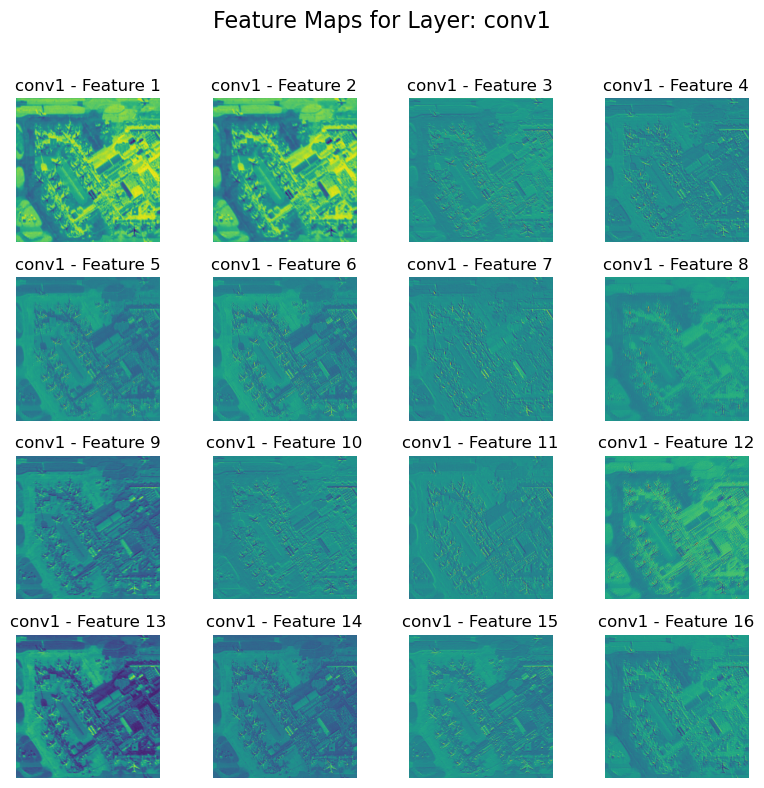

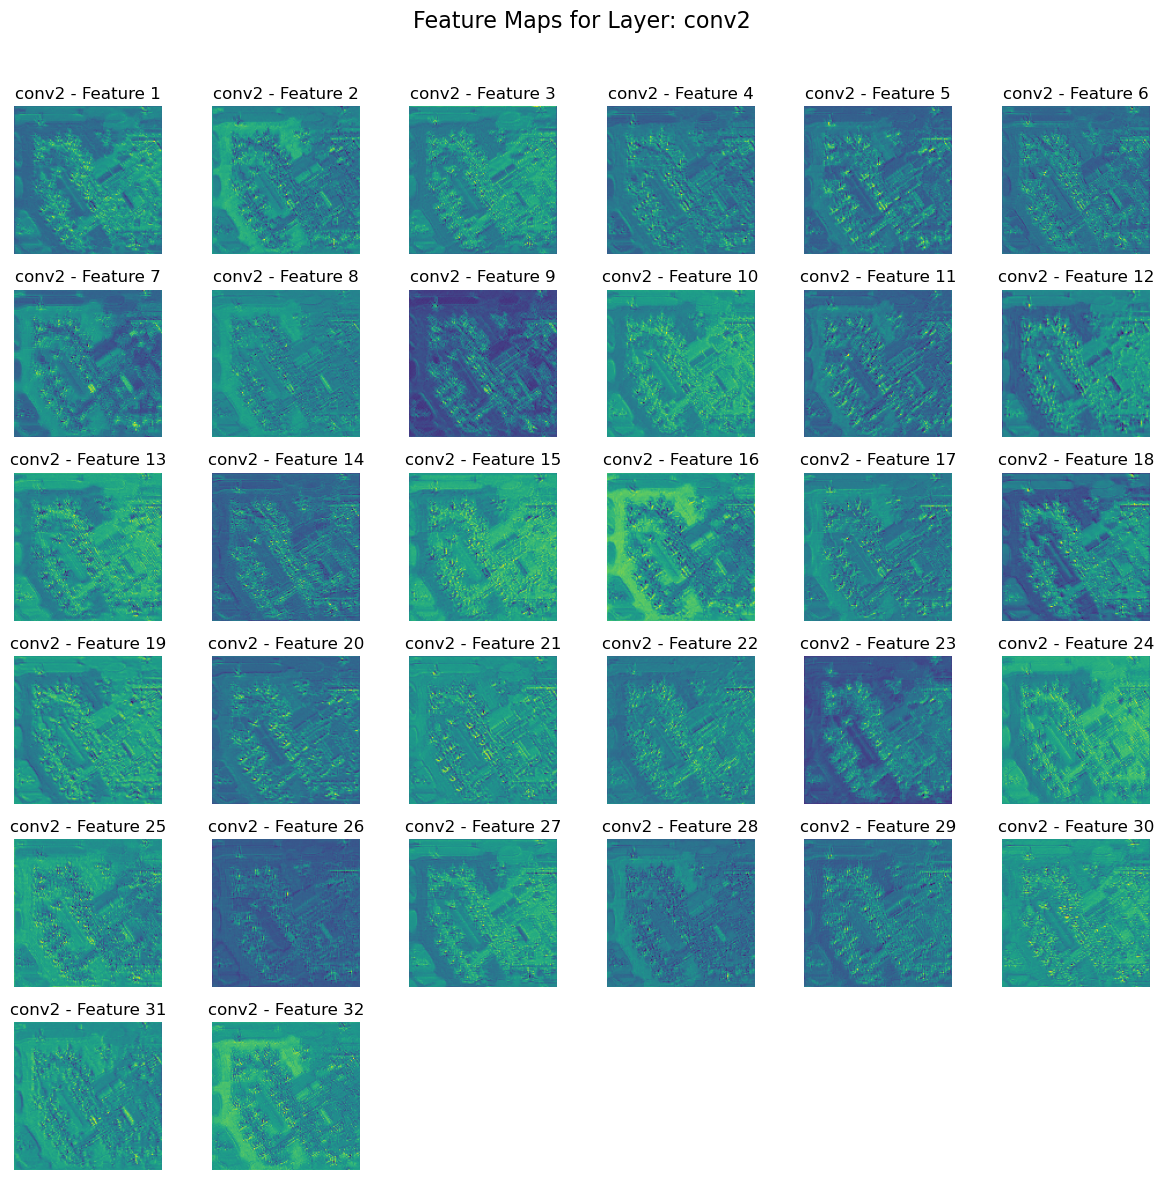

In [16]:
visualize_feature_maps(
  model=example_model,
  image_tensor=val_images,
  layers_to_visualize=['conv1', 'conv2']
)